Loading embeddings from: ./embeddings/final_embeddings_molecules_20250308_221455.pkl
Loaded 41 embeddings
Rebuilding molecules from graph data...
Successfully rebuilt 41 molecules
Reducing dimensionality with UMAP...


C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Malli\anaconda3\envs\baceenv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Calculating molecular weights...
Finding representative molecules...
Creating visualization...
Visualization saved to: ./visualizations/molecular_embedding_space.png
Done!


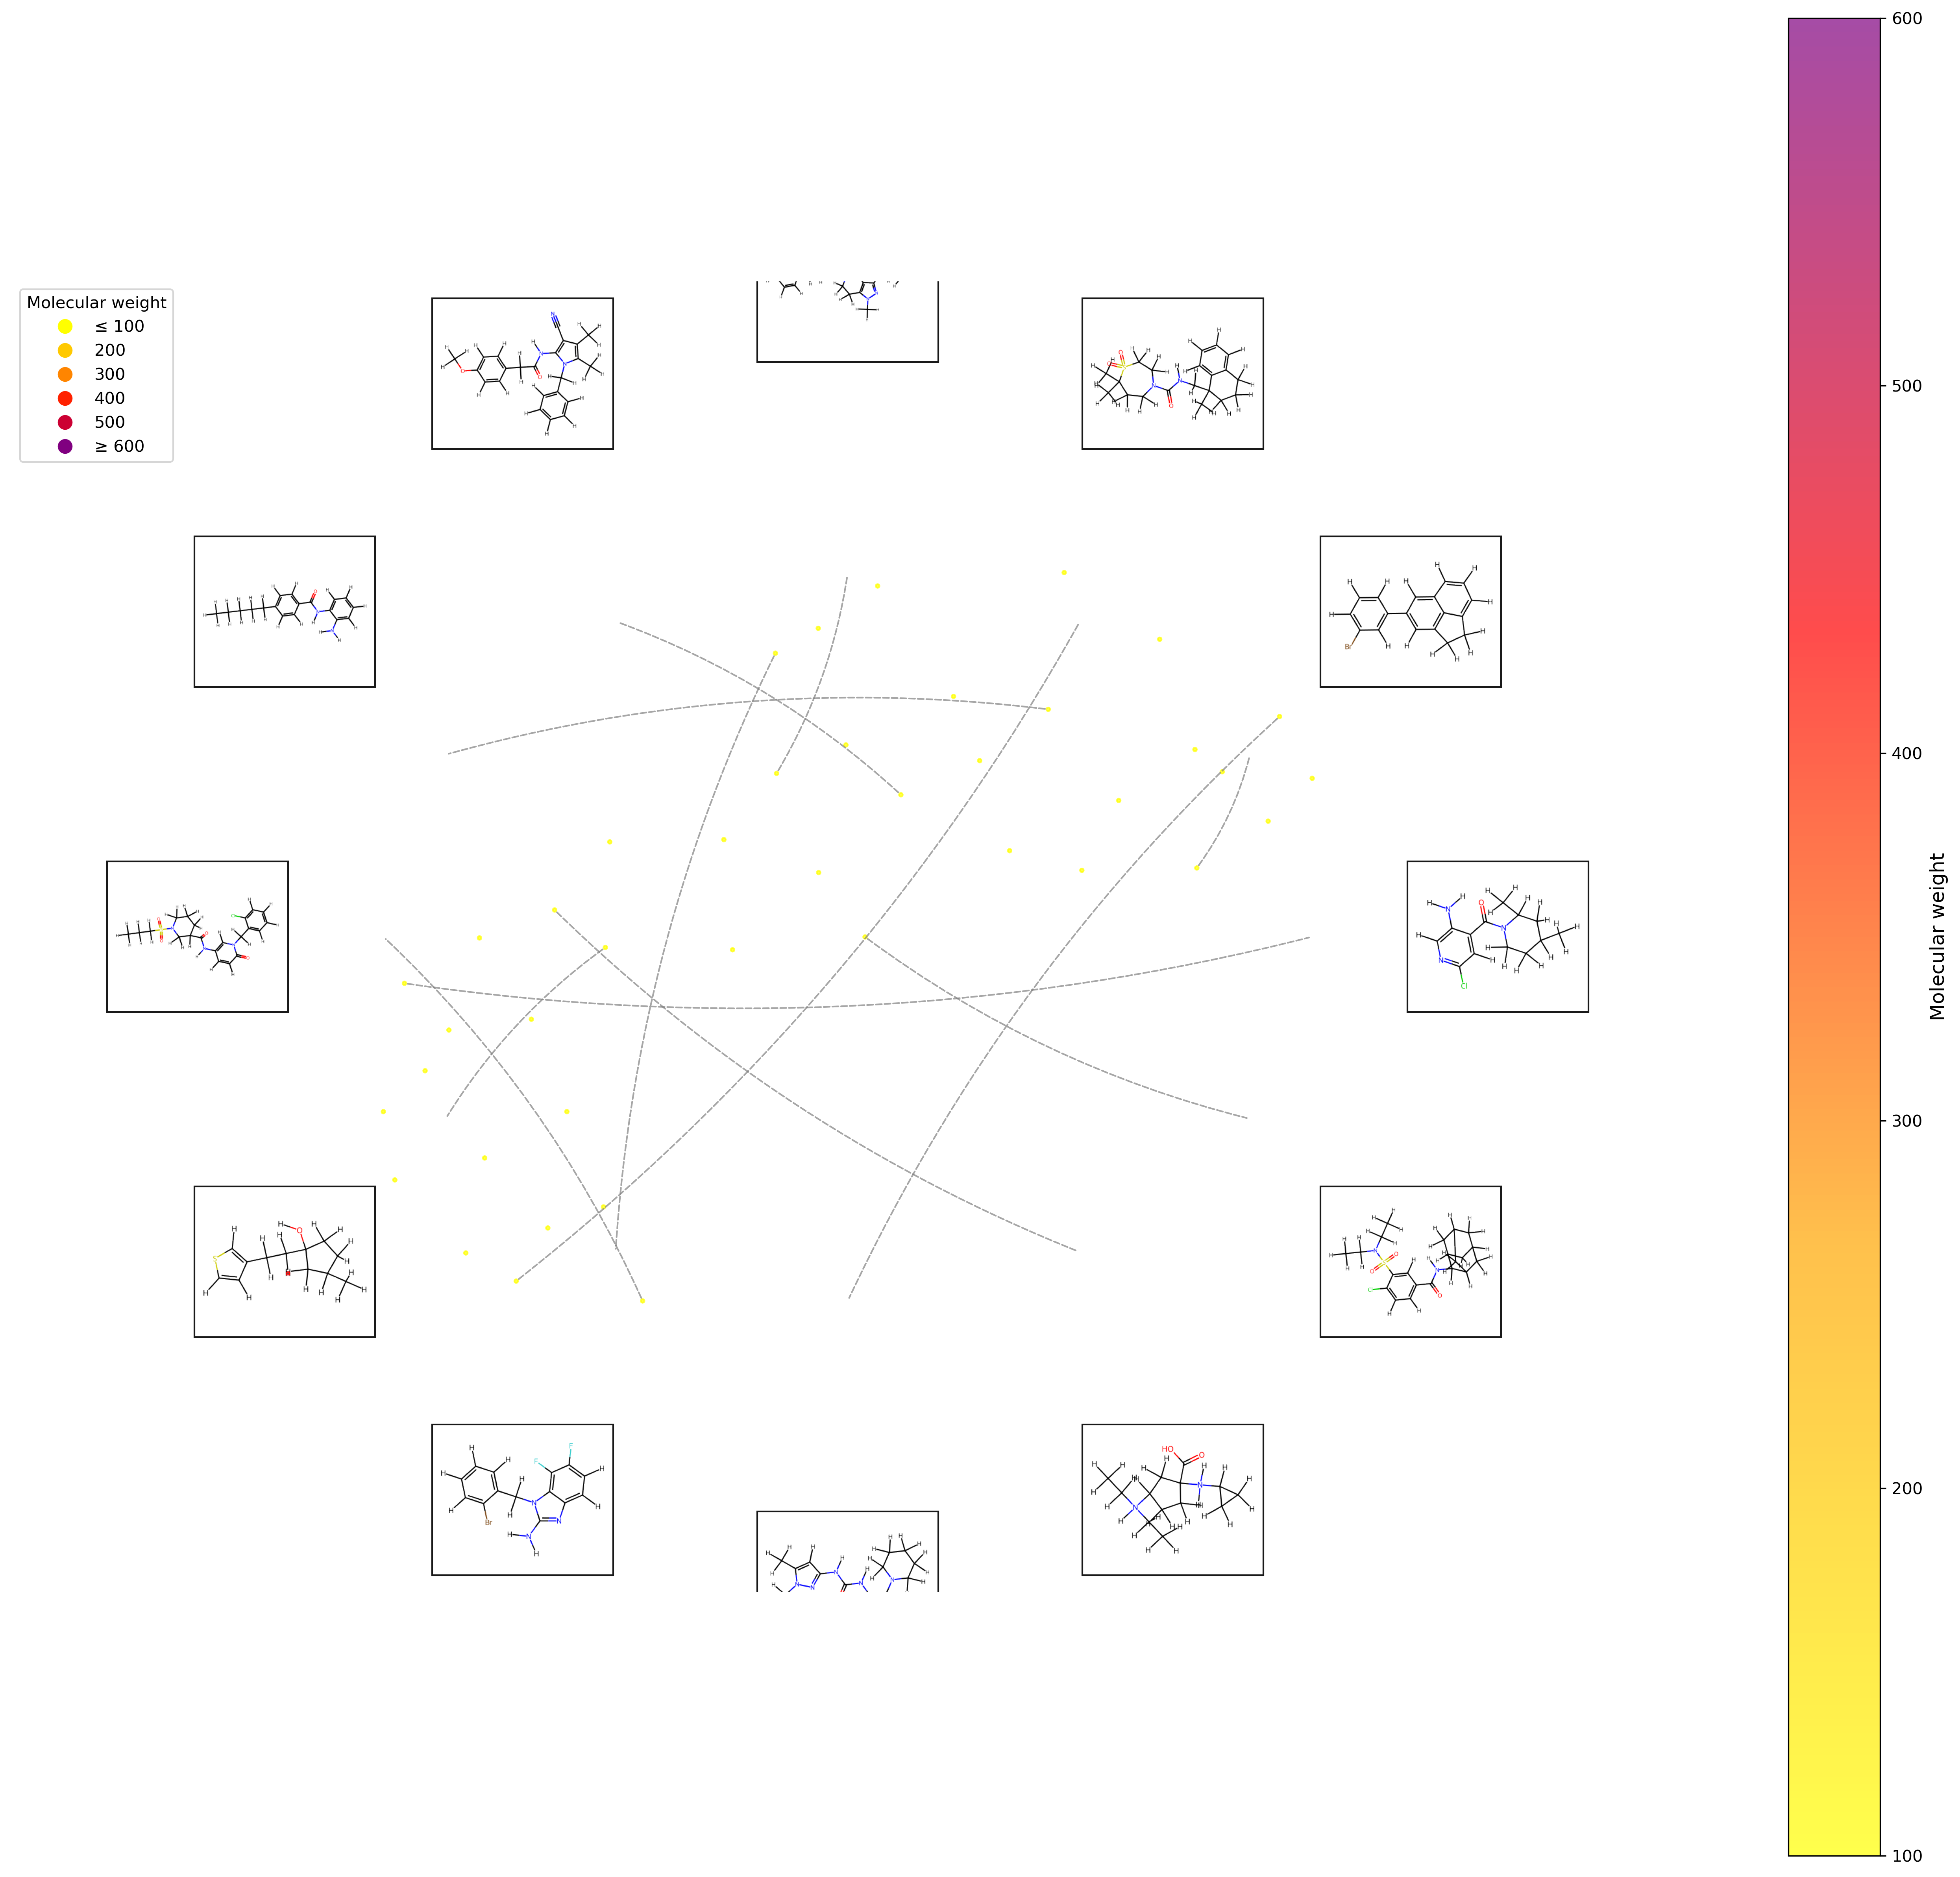

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import FancyArrowPatch, Rectangle
import matplotlib.patheffects as PathEffects
import umap
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from PIL import Image
import io
import os
from matplotlib.lines import Line2D
from rdkit import RDLogger
import random

# Suppress RDKit logging
RDLogger.DisableLog('rdApp.*')

def load_embeddings(filepath):
    """Load embeddings and molecule data from file"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = data['embeddings']
    molecule_data = data.get('molecule_data', None)
    
    return embeddings, molecule_data

def rebuild_molecules_from_graph_data(molecule_data_list):
    """Reconstruct RDKit molecules from graph data - simplified version"""
    # Maps for atom and bond features
    atom_list = list(range(1, 119))
    bond_list = [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE, 
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ]
    
    molecules = []
    for mol_data in molecule_data_list:
        try:
            # Create empty editable molecule
            mol = Chem.RWMol()
            
            # Add atoms based on x_cat data
            x_cat = mol_data.get('x_cat')
            if x_cat is None:
                molecules.append(None)
                continue
                
            for atom_features in x_cat:
                atomic_num = atom_list[atom_features[0]]
                atom = Chem.Atom(atomic_num)
                mol.AddAtom(atom)
            
            # Add bonds based on edge_index and edge_attr
            edge_index = mol_data.get('edge_index')
            edge_attr = mol_data.get('edge_attr')
            
            if edge_index is None or edge_attr is None:
                molecules.append(None)
                continue
                
            # Process only in one direction (undirected edges appear twice)
            processed_edges = set()
            
            for i in range(len(edge_index[0])):
                start, end = edge_index[0][i], edge_index[1][i]
                if (start, end) in processed_edges or (end, start) in processed_edges:
                    continue
                
                # Skip invalid indices
                if start >= mol.GetNumAtoms() or end >= mol.GetNumAtoms():
                    continue
                    
                # Add the bond
                try:
                    bond_type_idx = int(edge_attr[i][0])
                    if bond_type_idx < len(bond_list):
                        bond_type = bond_list[bond_type_idx]
                        mol.AddBond(start, end, bond_type)
                        processed_edges.add((start, end))
                except Exception:
                    continue
            
            # Convert to molecule
            try:
                final_mol = Chem.Mol(mol)
                for atom in final_mol.GetAtoms():
                    atom.UpdatePropertyCache(strict=False)
                
                # Try to sanitize, but proceed even if it fails
                try:
                    Chem.SanitizeMol(final_mol)
                except:
                    pass
                
                # Compute 2D coordinates
                AllChem.Compute2DCoords(final_mol)
                molecules.append(final_mol)
            except Exception:
                molecules.append(None)
                
        except Exception:
            molecules.append(None)
    
    return molecules

def mol_to_image(mol, size=(200, 180), kekulize=True):
    """Convert RDKit molecule to PIL Image with transparent background"""
    if mol is None:
        return None
    
    try:
        # Use RDKit's DrawMolToImage function
        img = Draw.MolToImage(mol, size=size, kekulize=kekulize, fitImage=True)
        
        # Convert to RGBA if not already
        if img.mode != 'RGBA':
            img = img.convert('RGBA')
        
        # Make white background transparent
        datas = img.getdata()
        newData = []
        for item in datas:
            if item[0] > 240 and item[1] > 240 and item[2] > 240:
                newData.append((255, 255, 255, 0))
            else:
                newData.append(item)
        
        img.putdata(newData)
        return img
    except Exception as e:
        print(f"Error rendering molecule: {e}")
        return None

def create_molecular_weight_colormap():
    """Create a custom colormap similar to the reference image"""
    # Define the colors from light yellow to dark red/purple
    colors = [
        (1.0, 1.0, 0.0),      # light yellow
        (1.0, 0.65, 0.0),     # orange
        (1.0, 0.0, 0.0),      # red
        (0.5, 0.0, 0.5)       # purple
    ]
    
    # Create colormap
    cmap = LinearSegmentedColormap.from_list("molecular_weight", colors)
    return cmap

def reduce_dimensions(embeddings, method='umap', n_components=2, **kwargs):
    """Reduce dimensionality of embeddings for visualization"""
    if method.lower() == 'tsne':
        from sklearn.manifold import TSNE
        reducer = TSNE(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'umap':
        import umap
        reducer = umap.UMAP(n_components=n_components, random_state=42, **kwargs)
    elif method.lower() == 'pca':
        from sklearn.decomposition import PCA
        reducer = PCA(n_components=n_components, **kwargs)
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {method}")
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

def find_representative_molecules(embeddings_2d, n_samples=12):
    """Find representative molecules throughout the embedding space"""
    # Use a grid-based approach to sample evenly
    x_min, x_max = embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max()
    y_min, y_max = embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max()
    
    # Add some margin
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    x_min -= x_range * 0.05
    x_max += x_range * 0.05
    y_min -= y_range * 0.05
    y_max += y_range * 0.05
    
    # Find dense regions (use a simple histogram approach)
    H, xedges, yedges = np.histogram2d(
        embeddings_2d[:, 0], embeddings_2d[:, 1], 
        bins=int(np.sqrt(n_samples*2)), 
        range=[[x_min, x_max], [y_min, y_max]]
    )
    
    # Find bins with high point density
    dense_cells = []
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            if H[i, j] > 0:
                dense_cells.append((i, j, H[i, j]))
    
    # Sort by density (descending)
    dense_cells.sort(key=lambda x: x[2], reverse=True)
    
    # Take top N cells
    selected_cells = dense_cells[:n_samples]
    
    # Find points in each cell
    selected_indices = []
    for i, j, _ in selected_cells:
        # Cell boundaries
        x_lower = xedges[i]
        x_upper = xedges[i+1]
        y_lower = yedges[j]
        y_upper = yedges[j+1]
        
        # Find points in this cell
        cell_mask = (
            (embeddings_2d[:, 0] >= x_lower) & 
            (embeddings_2d[:, 0] < x_upper) & 
            (embeddings_2d[:, 1] >= y_lower) & 
            (embeddings_2d[:, 1] < y_upper)
        )
        
        cell_indices = np.where(cell_mask)[0]
        
        if len(cell_indices) > 0:
            # Select a random point from this cell
            selected_idx = np.random.choice(cell_indices)
            selected_indices.append(selected_idx)
    
    # Ensure we have exactly n_samples (add random points if needed)
    if len(selected_indices) < n_samples:
        remaining = n_samples - len(selected_indices)
        available_indices = np.setdiff1d(np.arange(len(embeddings_2d)), selected_indices)
        
        if len(available_indices) >= remaining:
            additional = np.random.choice(available_indices, remaining, replace=False)
            selected_indices.extend(additional)
    
    return selected_indices[:n_samples]

def calculate_molecular_weights(molecules):
    """Calculate molecular weights for valid molecules"""
    weights = []
    for mol in molecules:
        if mol is None:
            weights.append(0)
        else:
            try:
                weights.append(Chem.Descriptors.MolWt(mol))
            except:
                weights.append(0)
    return np.array(weights)

def visualize_embedding_space(embeddings_2d, molecules, weights=None, selected_indices=None, 
                            figsize=(18, 16), dpi=300, save_path=None):
    """Visualize the embedding space with molecule structures"""
    if weights is None:
        # Use distance from center as a fallback
        center = np.mean(embeddings_2d, axis=0)
        weights = np.sqrt(np.sum((embeddings_2d - center)**2, axis=1))
        weights = (weights - weights.min()) / (weights.max() - weights.min()) * 600
    
    # Select representative molecules if not provided
    if selected_indices is None:
        selected_indices = find_representative_molecules(embeddings_2d, n_samples=12)
    
    # Filter out invalid indices or None molecules
    selected_indices = [idx for idx in selected_indices if idx < len(molecules) and molecules[idx] is not None]
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi, facecolor='white')
    
    # Create colormap
    cmap = create_molecular_weight_colormap()
    
    # Plot points
    scatter = ax.scatter(
        embeddings_2d[:, 0], embeddings_2d[:, 1],
        c=weights,
        cmap=cmap,
        alpha=0.7,
        s=5,
        vmin=100,
        vmax=600
    )
    
    # Create bounding boxes for the molecules
    x_min, x_max = embeddings_2d[:, 0].min(), embeddings_2d[:, 0].max()
    y_min, y_max = embeddings_2d[:, 1].min(), embeddings_2d[:, 1].max()
    
    # Add some margin
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    x_min -= x_range * 0.4
    x_max += x_range * 0.4
    y_min -= y_range * 0.4
    y_max += y_range * 0.4
    
    # Set axis limits with margin for molecule structures
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # Draw molecules around the plot
    for i, idx in enumerate(selected_indices):
        # Get molecule and coordinates
        mol = molecules[idx]
        x, y = embeddings_2d[idx]
        
        # Convert molecule to image
        img = mol_to_image(mol, size=(300, 250))
        if img is None:
            continue
        
        # Determine position for molecule image
        # Make sure molecules are placed outside the main cluster
        angle = 2 * np.pi * i / len(selected_indices)  # Place evenly around the circle
        
        # Calculate position for molecule image
        # Use angle to place around the perimeter
        mw = weights[idx] if idx < len(weights) else 300  # Fallback value
        
        # Adjust distance based on molecule size
        img_distance = max(x_range, y_range) * 0.7
        
        img_x = np.cos(angle) * img_distance
        img_y = np.sin(angle) * img_distance
        
        # Center in the plot
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        
        img_x += center_x
        img_y += center_y
        
        # Draw dashed line from point to molecule
        line = FancyArrowPatch(
            (x, y),
            (center_x + np.cos(angle) * (x_range * 0.5), center_y + np.sin(angle) * (y_range * 0.5)),
            connectionstyle="arc3,rad=0.1",
            arrowstyle="-",
            linestyle='--',
            color='gray',
            linewidth=1,
            alpha=0.7
        )
        ax.add_patch(line)
        
        # Add a white background for molecule with black border
        img_width = img.width / 300  # Scale for plot units
        img_height = img.height / 300
        
        # Create rectangle background
        rect = Rectangle(
            (img_x - img_width/2, img_y - img_height/2),
            img_width, img_height,
            facecolor='white',
            edgecolor='black',
            linewidth=1,
            alpha=0.9,
            zorder=5
        )
        ax.add_patch(rect)
        
        # Place molecule on top of rectangle
        ax.imshow(
            img, 
            extent=[
                img_x - img_width/2, img_x + img_width/2,
                img_y - img_height/2, img_y + img_height/2
            ],
            zorder=10
        )
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Molecular weight', fontsize=12)
    
    # Create custom legend for molecular weight
    weight_values = [100, 200, 300, 400, 500, 600]
    
    # Create a separate legend
    legend_elements = []
    for weight in weight_values:
        if weight == 100:
            label = '≤ 100'
        elif weight == 600:
            label = '≥ 600' 
        else:
            label = f'{weight}'
            
        color = cmap((weight - 100) / 500)
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                   markersize=10, label=label)
        )
    
    # Add legend
    ax.legend(
        handles=legend_elements,
        title='Molecular weight',
        loc='upper left',
        frameon=True,
        fontsize=10
    )
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Remove border
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Visualization saved to: {save_path}")
    
    return fig

def generate_dummy_embeddings_and_molecules(n_samples=5000):
    """Generate dummy data for testing when real data is unavailable"""
    print("Creating dummy data for testing...")
    
    # Generate simple 2D embeddings with a few clusters
    from sklearn.datasets import make_blobs
    embeddings, _ = make_blobs(
        n_samples=n_samples, 
        centers=8, 
        n_features=128, 
        random_state=42
    )
    
    # Generate some simple molecules
    smiles_list = [
        'CCO',               # Ethanol
        'CC(=O)O',           # Acetic acid
        'c1ccccc1',          # Benzene
        'CC(=O)OC',          # Methyl acetate
        'CCN',               # Ethylamine
        'CC(=O)N',           # Acetamide
        'c1ccccc1C(=O)O',    # Benzoic acid
        'CC1=CC=CC=C1',      # Toluene
        'c1ccc(cc1)O',       # Phenol
        'c1ccc(cc1)N',       # Aniline
        'c1cc(ccc1O)O',      # Hydroquinone
        'CC(C)CO',           # Isobutanol
        'CC(=O)c1ccccc1',    # Acetophenone
        'c1ccc(cc1)Cl',      # Chlorobenzene
        'c1ccc(cc1)Br',      # Bromobenzene
        'C1CCCCC1',          # Cyclohexane
        'c1ccncc1',          # Pyridine
        'C1CCOC1',           # Tetrahydrofuran
        'CCCN(C)C',          # N,N-dimethylpropylamine
        'CC(C)(C)O'          # tert-Butanol
    ]
    
    # Create random molecules from SMILES
    molecules = []
    for _ in range(n_samples):
        try:
            smiles = random.choice(smiles_list)
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                AllChem.Compute2DCoords(mol)
                molecules.append(mol)
            else:
                molecules.append(None)
        except:
            molecules.append(None)
    
    # Create dummy molecule data for the format expected
    molecule_data = []
    for mol in molecules:
        if mol is None:
            molecule_data.append(None)
            continue
            
        # Create minimal graph representation
        mol_data = {}
        
        # Add atoms
        x_cat = []
        for atom in mol.GetAtoms():
            x_cat.append([atom.GetAtomicNum(), 0])  # Atomic number and dummy chirality
        mol_data['x_cat'] = x_cat
        
        # Add bonds
        edge_index = [[], []]
        edge_attr = []
        
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            
            # Add in both directions for undirected graph
            edge_index[0].extend([i, j])
            edge_index[1].extend([j, i])
            
            # Bond type
            bond_type = int(bond.GetBondType())
            edge_attr.extend([[bond_type], [bond_type]])
        
        mol_data['edge_index'] = edge_index
        mol_data['edge_attr'] = edge_attr
        
        molecule_data.append(mol_data)
    
    return embeddings, molecule_data, molecules

def main():
    # Create output directory
    os.makedirs('./visualizations', exist_ok=True)
    
    # Try to load embeddings
    embeddings_path = './embeddings/final_embeddings_molecules_20250308_221455.pkl'  # Update with actual path
    
    try:
        print(f"Loading embeddings from: {embeddings_path}")
        embeddings, molecule_data = load_embeddings(embeddings_path)
        print(f"Loaded {len(embeddings)} embeddings")
        
        # Rebuild molecules
        print("Rebuilding molecules from graph data...")
        molecules = rebuild_molecules_from_graph_data(molecule_data)
        print(f"Successfully rebuilt {sum(1 for m in molecules if m is not None)} molecules")
        
    except Exception as e:
        print(f"Error loading real data: {e}")
        print("Using dummy data instead...")
        embeddings, molecule_data, molecules = generate_dummy_embeddings_and_molecules()
    
    # Reduce dimensions
    print("Reducing dimensionality with UMAP...")
    try:
        embeddings_2d = reduce_dimensions(
            embeddings, 
            method='umap',
            n_neighbors=30,
            min_dist=0.1,
            metric='cosine'
        )
    except Exception as e:
        print(f"Error with UMAP: {e}")
        print("Falling back to PCA...")
        embeddings_2d = reduce_dimensions(embeddings, method='pca')
    
    # Calculate molecular weights
    print("Calculating molecular weights...")
    weights = calculate_molecular_weights(molecules)
    
    # Find representative molecules
    print("Finding representative molecules...")
    selected_indices = find_representative_molecules(embeddings_2d, n_samples=12)
    
    # Create visualization
    print("Creating visualization...")
    fig = visualize_embedding_space(
        embeddings_2d,
        molecules,
        weights,
        selected_indices,
        figsize=(18, 16),
        dpi=300,
        save_path='./visualizations/molecular_embedding_space.png'
    )
    
    print("Done!")

if __name__ == "__main__":
    main()